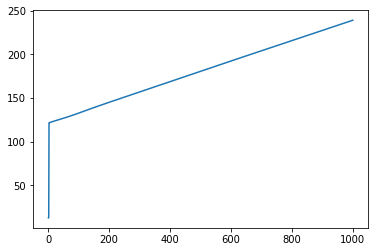

In [140]:
import random
import matplotlib.pyplot as plt
import numpy as np

#QUESTION (a):

'''
GILS implements the greedy iterated least squares price policy.
The INPUTS are as follows:

1) b_1, b_2, b_3, b_4 (floats): the bounds for the paramaters of the demand function, i.e.
0 <= b_1 <= theta_1 <= b_2 AND b_3 <= theta_3 <= b_4 <= 0.

2) min_p, max_p (floats): the bounds for the true price.

3) t (int): time stamp.

3) h (array of 2-tuples): the history of prices and demands up to time t. Namely:
h = [(p_1,d_1); (p_2,d_2); . . . ; (p_t,d_t)].

The OUTPUT is p_{t+1} (int), the price chosen by GILS for the next time stamp.
'''

def GILS(b_1, b_2, b_3, b_4, min_p, max_p, t, h):
    
    # Choose a random price for the first 2 time stamps.
    if t == 0:
        return random.uniform(min_p,max_p)
    if t == 1:
        p_1 = h[0][0]
        p_2 = random.uniform(min_p,max_p)
        while p_2 == p_1:
            p_2 = random.uniform(min_p,max_p)
        return p_2
    
    # If t>1, compute the least squares estimator (theta_1, theta_2).
    # We use the usual solution for ls estimator in linear regression.
    prices = [h[i][0] for i in range(t)]
    demands = [h[i][1] for i in range(t)]
    prod = [prices[i]*demands[i] for i in range(t)]
    pric_squar = [prices[i]*prices[i] for i in range(t)]
    
    theta_2 = (sum(prod) - (sum(prices)*sum(demands))/t)/(sum(pric_squar) - sum(prices)*sum(prices)/t)
    theta_1 = sum(demands)/t - theta_2*sum(prices)/t
    
    # Project them onto [b_1,b_2] x [b_3,b_4] if necessary
    if theta_1 < b_1:
        theta_1 = b_1
    if theta_1 > b_2:
        theta_1 = b_2
    if theta_2 < b_3:
        theta_2 = b_3
    if theta_2 > b_4:
        theta_2 = b_4
    
    # Return the perceived optimal price (assuming it will fall into [min_p, max_p])
    return -theta_1/(2*theta_2)


"""
Sign function determines the sign of a float.
If the float is greater or equal than 0 the return equals 1,
otherwise the return equals -1.
"""

def Sign(x):
    if x >= 0:
        return 1
    else:
        return -1
'''
CILS implements the constrained iterated least squares price policy. The INPUTS are
the same as for GILS with the threshold paramter K (float) added. OUTPUT is also p_{t+1}
'''

def CILS(b_1, b_2, b_3, b_4, min_p, max_p, t, h, K):
    
    #  Calculate the unconstrained price. 
    U_price = GILS(b_1, b_2, b_3, b_4, min_p, max_p, t, h)
    
    # Calculate the average of the prices up till time t
    A_price = 0
    if t > 0:
        for history in h:
            A_price += history[0]/(t)
    
    # Calculate  delta_t
    delta_t = U_price  - A_price
    
    # Calculate the constrained price
    if abs(delta_t) < K*((t+1)**(-1/4)):
        return A_price + Sign(delta_t)*K*((t+1)**(-1/4))
    else:
        return U_price

'''
Let us assume for now that b_1 = 0.01, b_2 = 1000, b_3 = -500, b_4 = -0.01, min_p = 0, max_p = 100.
And also that the true theta_1 = 10 and theta_2 = -0.5 so that D = 10 - 0.5*p.
'''
    
#QUESTION (b):

'''
REGRET_fixed(K, T, theta_1, theta_2) computes all the regrets for CILS(K) up to time T for 
true paramters theta_1, theta_2 fixed, and parameter K. 
'''

def REGRET_fixed(K, T, theta_1, theta_2):
    best_p = -theta_1/(2*theta_2) # the best price in hindsight
    regrets =[]
    h = []
    regret = 0
    for t in range(T):
        e_t = np.random.normal(0,1)
        p_t = CILS(0,1000,-500,0,0,30, t, h, K)
        d_t = theta_1 + theta_2*p_t +e_t
        regret += best_p*(theta_1 + theta_2*best_p) - p_t*(d_t-e_t)
        h.append((p_t,d_t))
        regrets.append(regret)
    return regrets

def main():
    # We compute the regret of CILS(0) for T = 1 to T = 1000.
    regrets = []
    regrets = REGRET_fixed(0, 1000, 10, -0.5)
    # Let us observe if it is linear by plotting regrets against T.
    time = [t+1 for t in range(1000)]
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.plot(time,regrets)
    plt.show()
    
if __name__ == '__main__':
    main()
    